# Acoustic Navigation Training Notebook

In [5]:
import torch
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)        # None => CPU-only build
print("cuda available:", torch.cuda.is_available())  # should be True
print("cuda built:", torch.backends.cuda.is_built()) # True if GPU build


torch: 2.9.1+cu126
built with CUDA: 12.6
cuda available: True
cuda built: True


In [6]:
import sys
sys.path.append('../')

import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader

from src.cave_dataset import (
    MultiCaveDataset,
    ACTION_MAP,
    ACTION_NAMES,
    MIC_OFFSETS,
    compute_class_distribution,
    compute_class_weights,
)
from src.models import FocalLoss, WavefrontNet, WideFieldNet
from src.lmdb_dataset import LMDBAcousticDataset

print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
np.random.seed(42)
torch.manual_seed(42)

2.9.1+cu126
Using device: cuda


In [7]:
# Cell 4+5: Perfectly Balanced Dataset (FIXED SEED)
# ---------------------------------------------------------
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import random
from pathlib import Path
from collections import defaultdict
from src.lmdb_dataset import LMDBAcousticDataset 

# --- CRITICAL FIX: Seed Python's Random Generator ---
# This ensures we pick the EXACT same 2,300 samples every time.
random.seed(42) 
np.random.seed(42)
torch.manual_seed(42)

# 1. Load Raw Data
DATASET_DIR = Path('D:/audiomaze_dataset_100')
raw_dataset = LMDBAcousticDataset('D:/audiomaze_lmdb_100')

# 2. Scan and Sort Indices by Class
print("Scanning dataset to group indices by class...")
indices_by_class = defaultdict(list)

for idx in range(len(raw_dataset)):
    _, action, _, _ = raw_dataset[idx]
    act = int(action)
    if act in [1, 2, 3, 4]: # 1=UP, 2=DOWN, 3=LEFT, 4=RIGHT
        indices_by_class[act].append(idx)

# 3. Dynamic Downsampling
min_count = min(len(indices_by_class[c]) for c in [1, 2, 3, 4])
print(f"\nClass Counts: { {k: len(v) for k,v in indices_by_class.items()} }")
print(f"--> Downsampling to: {min_count} samples per class")

# 4. Create Perfectly Balanced Index List
balanced_indices = []
for cls in [1, 2, 3, 4]:
    # Now this sampling is DETERMINISTIC due to random.seed(42)
    sampled = random.sample(indices_by_class[cls], min_count)
    balanced_indices.extend(sampled)

random.shuffle(balanced_indices)

# 5. Create Dataset & Split
balanced_dataset = Subset(raw_dataset, balanced_indices)
balanced_targets = [raw_dataset[i][1].item() for i in balanced_indices]

train_idx, val_idx = train_test_split(
    np.arange(len(balanced_dataset)), 
    test_size=0.2, 
    random_state=42, 
    stratify=balanced_targets
)

train_dataset = Subset(balanced_dataset, train_idx)
val_dataset = Subset(balanced_dataset, val_idx)

# 6. Loaders
# Lower batch size (128) helps generalization on small datasets
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n✅ Data Ready (Deterministic):")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val:   {len(val_dataset)} samples")

c:\Users\danyi\repo\Audio-Maze-Navigation\.venv\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.sparse import csr_matrix, issparse


Loaded LMDB dataset: 96,868 samples
Action distribution: {'stop': 100, 'up': 48697, 'down': 43300, 'left': 2318, 'right': 2453}
Scanning dataset to group indices by class...

Class Counts: {2: 43300, 4: 2453, 3: 2318, 1: 48697}
--> Downsampling to: 2318 samples per class

✅ Data Ready (Deterministic):
  Train: 7417 samples
  Val:   1855 samples


In [12]:
# Cell 6: Model Initialization (WavefrontNet - 2D)
# ---------------------------------------------------------
import torch
import torch.nn as nn
from src.models import WavefrontNet  # Import the new 2D model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the 2D Architecture
model = WavefrontNet(num_classes=4, dropout=0.5).to(device)

# 1e-3 is the "Aggressive" LR that worked for the 2D model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
criterion = torch.nn.CrossEntropyLoss()

print("✅ WavefrontNet (2D) Loaded from src.models")
print(f"   Device: {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

✅ WavefrontNet (2D) Loaded from src.models
   Device: cuda
   Parameters: 565,668


In [13]:
# Cell 7: Training Loop (With History Tracking & Checkpoints)
# ---------------------------------------------------------
from tqdm.auto import tqdm
import torch
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from contextlib import nullcontext

# Config
EPOCHS = 30
LR = 0.001
save_dir = Path("checkpoints")
save_dir.mkdir(parents=True, exist_ok=True)
best_val_acc = 0.0

# History Containers (For Plotting)
history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Re-init optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# AMP Setup
scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else torch.amp.GradScaler(enabled=False)
autocast_ctx = lambda: torch.amp.autocast('cuda') if torch.cuda.is_available() else nullcontext()

print("=" * 60)
print(f"STARTING WAVEFRONT TRAINING (LR={LR})")
print("=" * 60)

for epoch in range(EPOCHS):
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}", dynamic_ncols=True, colour="#4CAF50")
    for mic, action, _, _ in pbar:
        mic = mic.to(device, non_blocking=True)
        targets = (action - 1).to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        with autocast_ctx():
            logits = model(mic)
            loss = criterion(logits, targets)
            
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        train_correct += (preds == targets).sum().item()
        train_total += targets.numel()
        
        pbar.set_postfix(loss=train_loss/train_total, acc=train_correct/train_total)

    # Record Training Stats
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_correct / train_total
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)

    # --- VALIDATION ---
    model.eval()
    val_correct = 0
    val_total = 0
    val_pred_counts = {0:0, 1:0, 2:0, 3:0} 
    
    with torch.no_grad():
        for mic, action, _, _ in val_loader:
            mic = mic.to(device, non_blocking=True)
            targets = (action - 1).to(device)

            with autocast_ctx():
                logits = model(mic)
            
            preds = logits.argmax(dim=1)
            val_correct += (preds == targets).sum().item()
            val_total += targets.numel()
            
            for p in preds.tolist():
                val_pred_counts[p] += 1

    avg_val_acc = val_correct / val_total
    history['val_acc'].append(avg_val_acc)
    
    scheduler.step(avg_val_acc)
    
    # Distribution Check
    total_preds = sum(val_pred_counts.values())
    dist_str = " | ".join([f"{k}:{v/total_preds:.0%}" for k,v in val_pred_counts.items()])
    
    print(f"\nSummary Ep {epoch+1}: Val Acc {avg_val_acc:.3f} | Train Acc {avg_train_acc:.3f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"  Pred Distribution: {dist_str}")
    
    # Save Best Model
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), save_dir / "best_model_wavefront.pt")
        print("  --> Saved Best Model")

    # Periodic Checkpoint
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), save_dir / f"wavefront_epoch_{epoch+1}.pt")
        
    print("-" * 60)

STARTING WAVEFRONT TRAINING (LR=0.001)


Ep 1/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 1: Val Acc 0.250 | Train Acc 0.277 | LR: 1.00e-03
  Pred Distribution: 0:100% | 1:0% | 2:0% | 3:0%
  --> Saved Best Model
------------------------------------------------------------


Ep 2/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 2: Val Acc 0.250 | Train Acc 0.440 | LR: 1.00e-03
  Pred Distribution: 0:0% | 1:0% | 2:0% | 3:100%
------------------------------------------------------------


Ep 3/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 3: Val Acc 0.250 | Train Acc 0.726 | LR: 1.00e-03
  Pred Distribution: 0:0% | 1:100% | 2:0% | 3:0%
------------------------------------------------------------


Ep 4/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 4: Val Acc 0.293 | Train Acc 0.939 | LR: 1.00e-03
  Pred Distribution: 0:20% | 1:0% | 2:80% | 3:0%
  --> Saved Best Model
------------------------------------------------------------


Ep 5/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 5: Val Acc 0.250 | Train Acc 0.989 | LR: 1.00e-03
  Pred Distribution: 0:0% | 1:0% | 2:0% | 3:100%
------------------------------------------------------------


Ep 6/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 6: Val Acc 0.250 | Train Acc 0.995 | LR: 1.00e-03
  Pred Distribution: 0:0% | 1:100% | 2:0% | 3:0%
------------------------------------------------------------


Ep 7/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 7: Val Acc 0.250 | Train Acc 0.995 | LR: 1.00e-03
  Pred Distribution: 0:0% | 1:100% | 2:0% | 3:0%
------------------------------------------------------------


Ep 8/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 8: Val Acc 0.257 | Train Acc 0.995 | LR: 5.00e-04
  Pred Distribution: 0:0% | 1:3% | 2:0% | 3:97%
------------------------------------------------------------


Ep 9/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 9: Val Acc 0.250 | Train Acc 0.998 | LR: 5.00e-04
  Pred Distribution: 0:0% | 1:0% | 2:100% | 3:0%
------------------------------------------------------------


Ep 10/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 10: Val Acc 0.308 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:71% | 1:0% | 2:0% | 3:29%
  --> Saved Best Model
------------------------------------------------------------


Ep 11/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 11: Val Acc 0.250 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:0% | 1:100% | 2:0% | 3:0%
------------------------------------------------------------


Ep 12/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 12: Val Acc 0.352 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:19% | 1:7% | 2:17% | 3:57%
  --> Saved Best Model
------------------------------------------------------------


Ep 13/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 13: Val Acc 0.367 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:47% | 1:2% | 2:33% | 3:18%
  --> Saved Best Model
------------------------------------------------------------


Ep 14/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 14: Val Acc 0.346 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:15% | 1:13% | 2:9% | 3:63%
------------------------------------------------------------


Ep 15/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 15: Val Acc 0.356 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:12% | 1:50% | 2:6% | 3:32%
------------------------------------------------------------


Ep 16/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 16: Val Acc 0.374 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:32% | 1:41% | 2:16% | 3:11%
  --> Saved Best Model
------------------------------------------------------------


Ep 17/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 17: Val Acc 0.358 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:17% | 1:48% | 2:29% | 3:6%
------------------------------------------------------------


Ep 18/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 18: Val Acc 0.387 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:35% | 1:13% | 2:35% | 3:17%
  --> Saved Best Model
------------------------------------------------------------


Ep 19/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 19: Val Acc 0.319 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:32% | 1:0% | 2:2% | 3:66%
------------------------------------------------------------


Ep 20/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 20: Val Acc 0.387 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:16% | 1:24% | 2:35% | 3:25%
------------------------------------------------------------


Ep 21/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 21: Val Acc 0.361 | Train Acc 1.000 | LR: 5.00e-04
  Pred Distribution: 0:20% | 1:58% | 2:13% | 3:9%
------------------------------------------------------------


Ep 22/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 22: Val Acc 0.375 | Train Acc 1.000 | LR: 2.50e-04
  Pred Distribution: 0:8% | 1:32% | 2:42% | 3:18%
------------------------------------------------------------


Ep 23/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 23: Val Acc 0.375 | Train Acc 1.000 | LR: 2.50e-04
  Pred Distribution: 0:26% | 1:19% | 2:8% | 3:46%
------------------------------------------------------------


Ep 24/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 24: Val Acc 0.386 | Train Acc 1.000 | LR: 2.50e-04
  Pred Distribution: 0:18% | 1:27% | 2:27% | 3:28%
------------------------------------------------------------


Ep 25/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 25: Val Acc 0.378 | Train Acc 1.000 | LR: 2.50e-04
  Pred Distribution: 0:18% | 1:35% | 2:27% | 3:20%
------------------------------------------------------------


Ep 26/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 26: Val Acc 0.353 | Train Acc 1.000 | LR: 1.25e-04
  Pred Distribution: 0:16% | 1:11% | 2:17% | 3:57%
------------------------------------------------------------


Ep 27/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 27: Val Acc 0.391 | Train Acc 1.000 | LR: 1.25e-04
  Pred Distribution: 0:26% | 1:26% | 2:25% | 3:23%
  --> Saved Best Model
------------------------------------------------------------


Ep 28/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 28: Val Acc 0.389 | Train Acc 1.000 | LR: 1.25e-04
  Pred Distribution: 0:21% | 1:28% | 2:24% | 3:28%
------------------------------------------------------------


Ep 29/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 29: Val Acc 0.392 | Train Acc 1.000 | LR: 1.25e-04
  Pred Distribution: 0:26% | 1:21% | 2:27% | 3:25%
  --> Saved Best Model
------------------------------------------------------------


Ep 30/30:   0%|          | 0/29 [00:00<?, ?it/s]


Summary Ep 30: Val Acc 0.388 | Train Acc 1.000 | LR: 1.25e-04
  Pred Distribution: 0:22% | 1:26% | 2:31% | 3:22%
------------------------------------------------------------


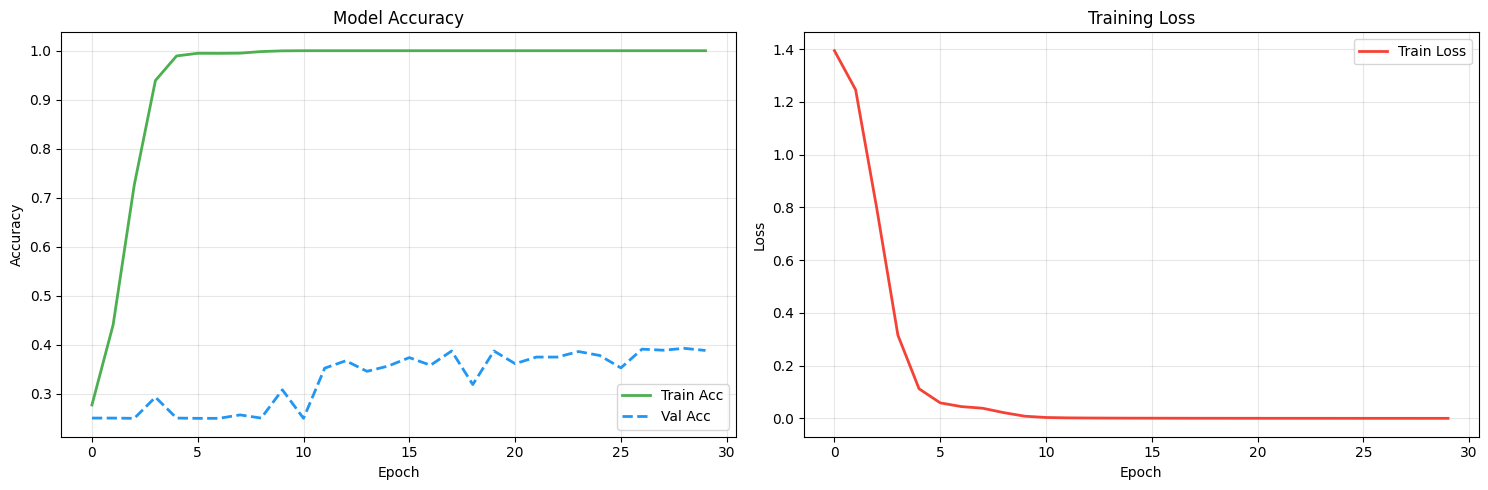


FINAL EVALUATION (Best Val Acc: 39.2%)
Loaded weights from checkpoints\best_model_wavefront.pt


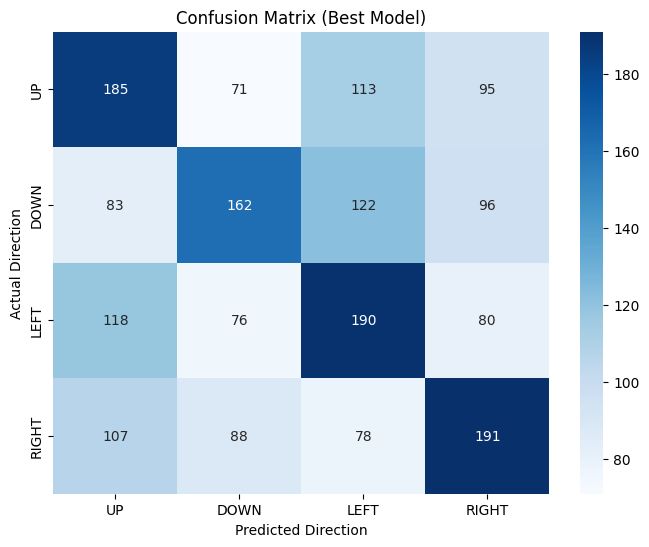


Classification Report:
              precision    recall  f1-score   support

          UP       0.38      0.40      0.39       464
        DOWN       0.41      0.35      0.38       463
        LEFT       0.38      0.41      0.39       464
       RIGHT       0.41      0.41      0.41       464

    accuracy                           0.39      1855
   macro avg       0.39      0.39      0.39      1855
weighted avg       0.39      0.39      0.39      1855



In [14]:
# Cell 8: Training Visualization & Final Metrics
# ---------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy Plot
ax1.plot(history['train_acc'], label='Train Acc', color='#4CAF50', linewidth=2)
ax1.plot(history['val_acc'], label='Val Acc', color='#2196F3', linewidth=2, linestyle='--')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss Plot
ax2.plot(history['train_loss'], label='Train Loss', color='#F44336', linewidth=2)
ax2.set_title('Training Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Final Evaluation on Best Model
print("\n" + "="*40)
print(f"FINAL EVALUATION (Best Val Acc: {best_val_acc:.1%})")
print("="*40)

# Load the best model weights
best_model_path = save_dir / "best_model_wavefront.pt"
if best_model_path.exists():
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded weights from {best_model_path}")

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for mic, action, _, _ in val_loader:
        mic = mic.to(device)
        targets = (action - 1).to(device)
        logits = model(mic)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

class_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']

# 3. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Best Model)')
plt.ylabel('Actual Direction')
plt.xlabel('Predicted Direction')
plt.show()

# 4. Detailed Report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names))